# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Jonah Lin

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


In [3]:
list(nhanes_scaled.columns).index('INDFMPIR'), list(nhanes_scaled.columns).index('BMXBMI')

(175, 76)

In [4]:
nhanes_scaled.shape

(2064, 242)

## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

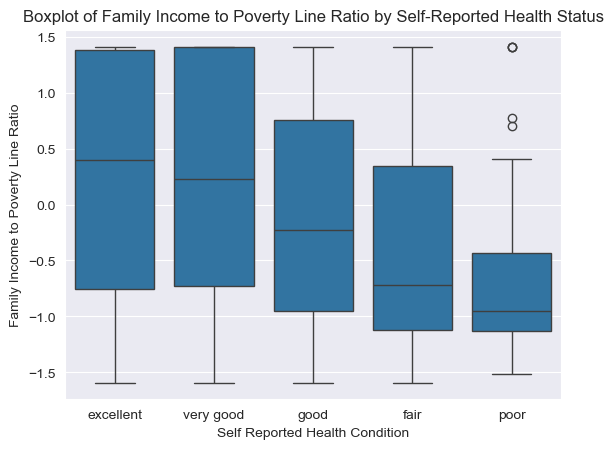

In [5]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

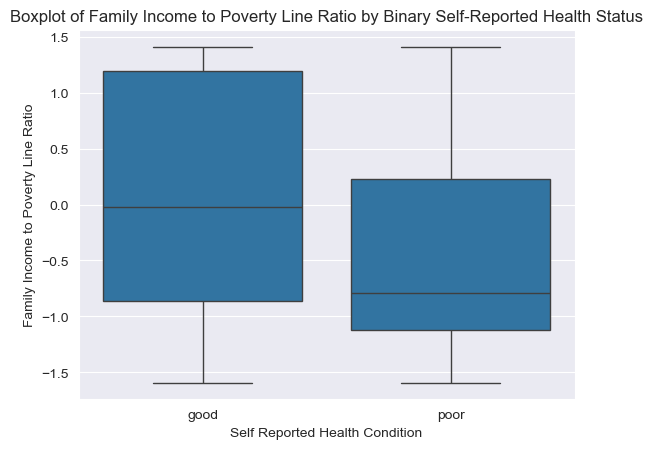

In [6]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

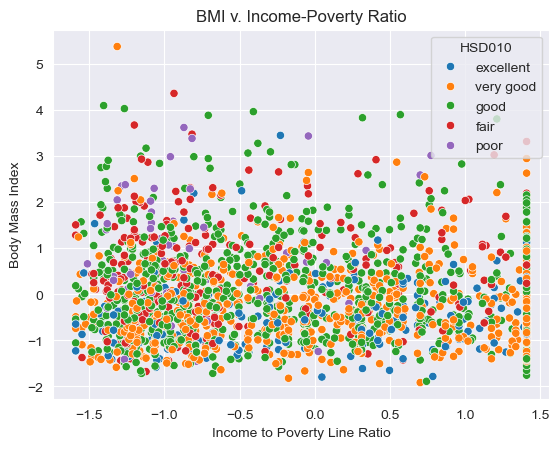

In [7]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [8]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

# nhanes_scaled['HSD010']

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

**Answer:**
\
Because the variance explained by each component is not clear at this point, I want to choose as many components as possible. But to plot all the chosen components, it shouldn't be larger than 100 or 200. So, I choose 80.

In [9]:
## Your Answer Here


X = StandardScaler().fit_transform(nhanes_scaled.values) 


pca_all = PCA() # notice we do not specify the number of components if we want to keep them all
principalComponents_nhanes = pca_all.fit_transform(X)

In [10]:
pca_80 = PCA(n_components=80) # notice we do not specify the number of components if we want to keep them all
PCA_80_components = pca_80.fit_transform(X)

In [11]:
sum(pca_80.explained_variance_ratio_) / sum(pca_all.explained_variance_ratio_)

0.7757514165140794

### Barplot of Components

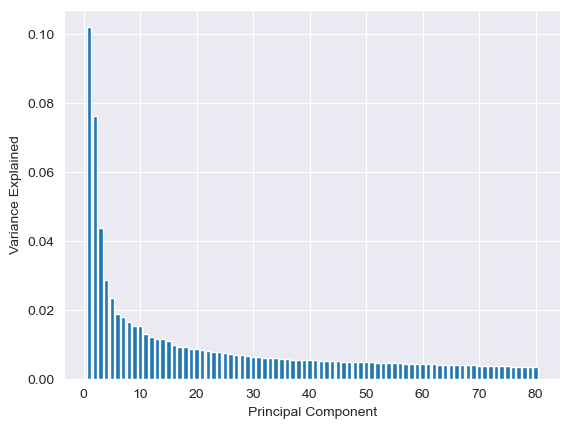

In [12]:
## Your Answer Here

PC_values = np.arange(pca_80.n_components_) + 1

plt.bar(PC_values, pca_80.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

### How many components will you use to fit a supervised learning model?

**Answer:**
\
I choose 40 components for supervised learning later. As shown below, 40 components can explain almost 60% of all variance of the dataset.

In [13]:
## Your Answer Here


pca_40 = PCA(n_components=40) # notice we do not specify the number of components if we want to keep them all
PCA_40_components = pca_40.fit_transform(X)

sum(pca_40.explained_variance_ratio_)

0.5954159388180538

In [14]:
PCA_40_components

array([[ 9.52781227, -0.81622163, -1.86715665, ...,  1.3166619 ,
         0.81649406,  0.58048408],
       [-5.83834973, -3.69257955,  3.80598736, ..., -3.34123707,
        -0.0976042 ,  1.19342217],
       [-0.71946201, -2.57320234,  0.9077817 , ...,  0.93796165,
        -0.61886379,  0.8442313 ],
       ...,
       [ 1.13024555, -0.97042182,  3.4153764 , ...,  2.29994501,
        -0.84587084, -0.64156506],
       [ 7.14509104, -0.37675719,  1.75343821, ...,  0.10272513,
        -0.11617143,  0.66542522],
       [ 0.05086734, -0.96730261, -4.44775644, ...,  0.39035274,
         0.16283444,  1.58858932]])

In [15]:
PCA_40_components.shape

(2064, 40)

In [16]:
X.shape

(2064, 241)

### 2D Scatterplot of the first two components

<Figure size 640x480 with 0 Axes>

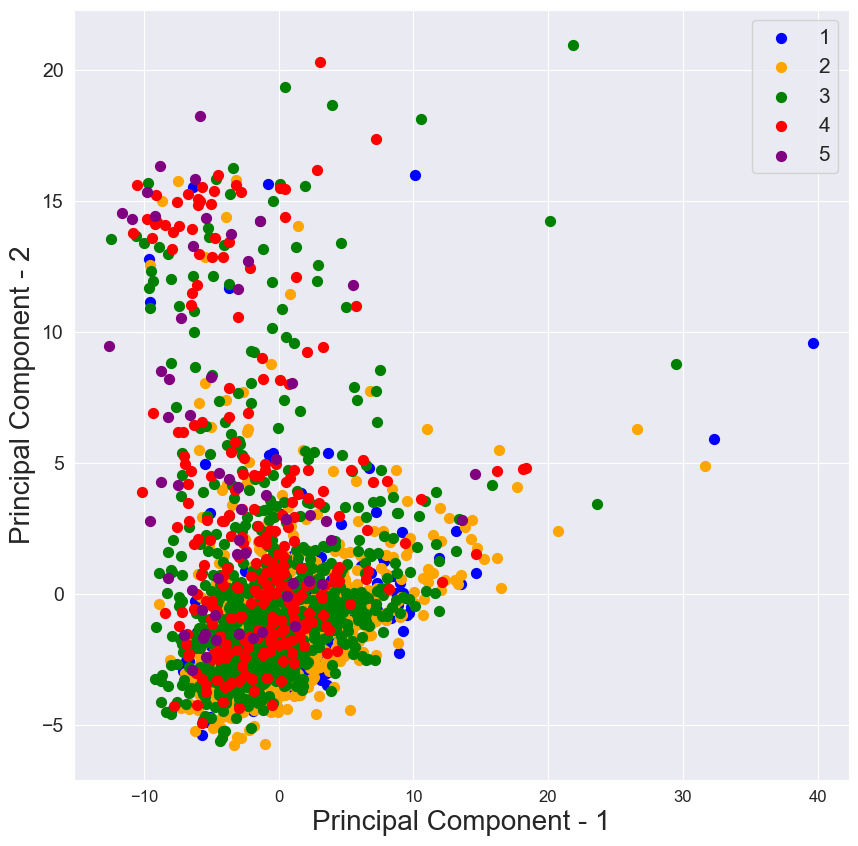

In [17]:
## Your Answer Here


pca_df = pd.DataFrame(data = PCA_40_components[:,:2], 
                      columns = ['principal component 1', 
                                 'principal component 2'])

# figure settings
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
targets = [1, 2, 3, 4, 5]
colors = ['blue', 'orange', 'green', 'red', 'purple']

# loop over targets and colors to create scatterplot
for target, color in zip(targets,colors):
    indicesToKeep = hsd010 == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1'], 
                pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

# show figure
plt.legend(targets,prop={'size': 15})
plt.show();

**Answer:**
\
From the figure, it is hard to tell a distribution pattern of the results (1=excellent, 2=very good...). It means the first two components do not catch enough variance of the data to show a pattern.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

In [18]:
## Your Answer Here

**Answer:**
\
K-means.
There is no obvious pattern of the distribution that makes any algorithms a better fit. With K-means, the number of clusters can be adjusted to find a (near) optimal cluster count that reduces the variance within clusters while not making too many clusters.

### Cluster nhanes

In [19]:
## Your Answer Here

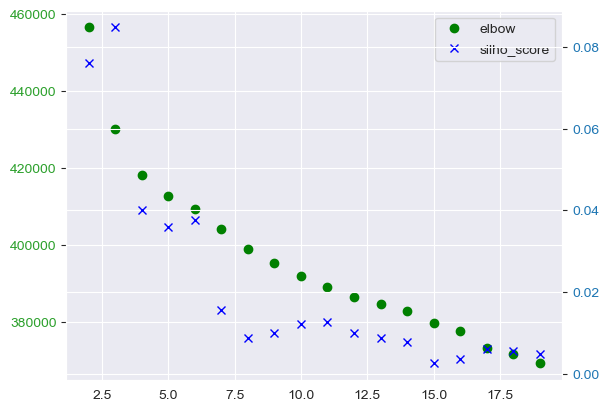

In [20]:
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = list(range(2,20))
silho_score_list = []
distorsions = []

for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10).fit(X)
    cluster_labels = clusterer.predict(X)
    
    distorsions.append(clusterer.inertia_)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    silho_score_list.append(silhouette_avg)

fig, ax1 = plt.subplots()
line1, = ax1.plot(range_n_clusters, distorsions, 'go', label="elbow")
ax1.tick_params(axis='y', labelcolor='tab:green')

ax2 = ax1.twinx()
line2, = ax2.plot(range_n_clusters, silho_score_list, 'bx', label="silho_score")
ax2.tick_params(axis='y', labelcolor='tab:blue')

lines = [line1, line2]
labels = [line.get_label() for line in lines]

ax1.legend(lines, labels)

plt.show()

**Answer:**
\
The there is an elblow point at cluster_number=5, while the silhouette score remains relatively high. Plus, the number of clusters to be predicted for hsd010 is 5.

In [21]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

/Users/zhounanlin/anaconda3/envs/anlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [22]:
## Your Answer Here

In [23]:
X.shape

(2064, 241)

In [24]:
X[kmeans.labels_==0,:].shape

(150, 241)

In [25]:
X[kmeans.labels_==0,:][:2,:].shape

(2, 241)

In [26]:
# kmeans.cluster_centers_[:2,:]

In [27]:
X[kmeans.labels_==0,:].shape

(150, 241)

In [28]:
# X[kmeans.labels_==0,:][:, [175, 76]].T

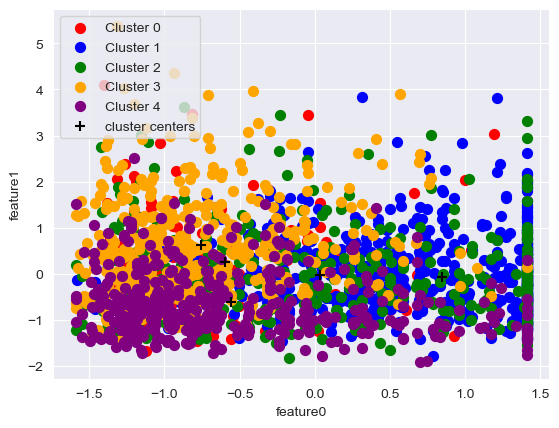

In [29]:
# figure settings
fig = plt.figure()
ax1 = fig.add_subplot(111)

# plot
ax1.scatter(*(X[kmeans.labels_==0,:][:, [175, 76]].T), s=50, c='r', label='Cluster 0')
ax1.scatter(*(X[kmeans.labels_==1,:][:, [175, 76]].T), s=50, c='b', label='Cluster 1')
ax1.scatter(*(X[kmeans.labels_==2,:][:, [175, 76]].T), s=50, c='g', label='Cluster 2')
ax1.scatter(*(X[kmeans.labels_==3,:][:, [175, 76]].T), s=50, c='orange', label='Cluster 3')
ax1.scatter(*(X[kmeans.labels_==4,:][:, [175, 76]].T), s=50, c='purple', label='Cluster 4')
ax1.scatter(*kmeans.cluster_centers_[:, [175, 76]].T, s=50, marker='+', c='black', label='cluster centers')
plt.legend(loc='upper left')
plt.xlabel('feature0')
plt.ylabel('feature1')
plt.show()

## Your Answer Here

**Answer:**
\
The resulting clusters do show some patterns. The blue cluster seems to be centered around the bottom right, while the purple cluster seems to be centered around bottom left. However, it not clear at this point which cluster corresponds to which HSD010 (self reported health condition).

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [30]:
## Your Answer Here

In [31]:
kmeans_2 = KMeans(n_clusters=5, random_state=0).fit(PCA_40_components)

/Users/zhounanlin/anaconda3/envs/anlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [32]:
PCA_40_components[kmeans_2.labels_==4,:].shape

(411, 40)

In [33]:
kmeans_2.cluster_centers_[:, :2].T

array([[ 7.5189808 , -2.49179081, -0.23465848, -4.22866598, -2.27696012],
       [ 0.6528087 , -2.49067526, -2.06027956, 12.21598361,  1.18515437]])

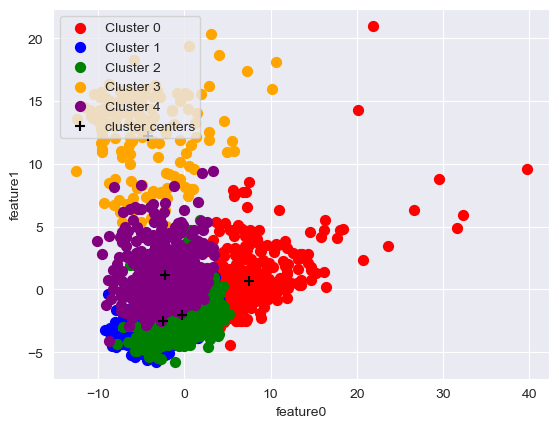

In [34]:
# figure settings
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

# plot
ax2.scatter(*(PCA_40_components[kmeans_2.labels_==0,:][:, :2].T), s=50, c='r', label='Cluster 0')
ax2.scatter(*(PCA_40_components[kmeans_2.labels_==1,:][:, :2].T), s=50, c='b', label='Cluster 1')
ax2.scatter(*(PCA_40_components[kmeans_2.labels_==2,:][:, :2].T), s=50, c='g', label='Cluster 2')
ax2.scatter(*(PCA_40_components[kmeans_2.labels_==3,:][:, :2].T), s=50, c='orange', label='Cluster 3')
ax2.scatter(*(PCA_40_components[kmeans_2.labels_==4,:][:, :2].T), s=50, c='purple', label='Cluster 4')
ax2.scatter(*kmeans_2.cluster_centers_[:, :2].T, s=50, marker='+', c='black', label='cluster centers')
plt.legend(loc='upper left')
plt.xlabel('feature0')
plt.ylabel('feature1')
plt.show()

## Your Answer Here

**Answer:**
\
A clear distribution pattern is visible in the figure above.
\
However, comparing this figure to the figure in "2D Scatterplot of the first two components" of PCA analysis section, the five clusters achieved from the kmeans clustering of PCA components is not very accurate.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [35]:
## Your Answer Here

In [36]:
# partition data
# -----------
y = hsd010 # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X_nn = X # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X_nn, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)


# keras.utils.to_categorical
# starts index from 0
# so, reduce y_train and y_test by 1

y_train -= 1
y_test -= 1

In [37]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 5
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [38]:
num_classes

5

In [39]:
X_train.shape

(1548, 241)

In [40]:
%%time

# create neural network model
# -----------
model = Sequential()

model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

## Add any additional layers you wish here

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=2)

Epoch 1/20
8/8 - 0s - loss: 1.5363 - accuracy: 0.3030 - val_loss: 1.3648 - val_accuracy: 0.3992 - 181ms/epoch - 23ms/step
Epoch 2/20
8/8 - 0s - loss: 1.2269 - accuracy: 0.4871 - val_loss: 1.2818 - val_accuracy: 0.4457 - 17ms/epoch - 2ms/step
Epoch 3/20
8/8 - 0s - loss: 1.1266 - accuracy: 0.5342 - val_loss: 1.2451 - val_accuracy: 0.4438 - 22ms/epoch - 3ms/step
Epoch 4/20
8/8 - 0s - loss: 1.0441 - accuracy: 0.5659 - val_loss: 1.2224 - val_accuracy: 0.4438 - 23ms/epoch - 3ms/step
Epoch 5/20
8/8 - 0s - loss: 0.9798 - accuracy: 0.6098 - val_loss: 1.2116 - val_accuracy: 0.4671 - 19ms/epoch - 2ms/step
Epoch 6/20
8/8 - 0s - loss: 0.9243 - accuracy: 0.6479 - val_loss: 1.2100 - val_accuracy: 0.4593 - 18ms/epoch - 2ms/step
Epoch 7/20
8/8 - 0s - loss: 0.8734 - accuracy: 0.6680 - val_loss: 1.2061 - val_accuracy: 0.4574 - 18ms/epoch - 2ms/step
Epoch 8/20
8/8 - 0s - loss: 0.8245 - accuracy: 0.6964 - val_loss: 1.2120 - val_accuracy: 0.4709 - 19ms/epoch - 2ms/step
Epoch 9/20
8/8 - 0s - loss: 0.7760 - a

### Neural Network on Principal Components

In [41]:
## Your Answer Here

In [42]:
# partition data
# -----------
y = hsd010 # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X_nn = PCA_40_components # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X_nn, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)


# keras.utils.to_categorical
# starts index from 0
# so, reduce y_train and y_test by 1

y_train -= 1
y_test -= 1

In [43]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 5
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [44]:
num_classes

5

In [45]:
X_train.shape

(1548, 40)

In [46]:
%%time

# create neural network model
# -----------
model = Sequential()

model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

## Add any additional layers you wish here

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=2)

Epoch 1/20
8/8 - 0s - loss: 1.5903 - accuracy: 0.2474 - val_loss: 1.5602 - val_accuracy: 0.3469 - 149ms/epoch - 19ms/step
Epoch 2/20
8/8 - 0s - loss: 1.5324 - accuracy: 0.4063 - val_loss: 1.5083 - val_accuracy: 0.4322 - 13ms/epoch - 2ms/step
Epoch 3/20
8/8 - 0s - loss: 1.4802 - accuracy: 0.4535 - val_loss: 1.4617 - val_accuracy: 0.4457 - 13ms/epoch - 2ms/step
Epoch 4/20
8/8 - 0s - loss: 1.4325 - accuracy: 0.4632 - val_loss: 1.4193 - val_accuracy: 0.4496 - 12ms/epoch - 1ms/step
Epoch 5/20
8/8 - 0s - loss: 1.3872 - accuracy: 0.4638 - val_loss: 1.3823 - val_accuracy: 0.4593 - 16ms/epoch - 2ms/step
Epoch 6/20
8/8 - 0s - loss: 1.3476 - accuracy: 0.4716 - val_loss: 1.3500 - val_accuracy: 0.4612 - 15ms/epoch - 2ms/step
Epoch 7/20
8/8 - 0s - loss: 1.3122 - accuracy: 0.4755 - val_loss: 1.3235 - val_accuracy: 0.4612 - 16ms/epoch - 2ms/step
Epoch 8/20
8/8 - 0s - loss: 1.2809 - accuracy: 0.4780 - val_loss: 1.3022 - val_accuracy: 0.4593 - 18ms/epoch - 2ms/step
Epoch 9/20
8/8 - 0s - loss: 1.2545 - a

### Neural Network on Principal Components + Cluster Membership

In [47]:
## Your Answer Here

In [48]:
# np.hstack((PCA_40_components, kmeans_2.labels_.reshape(-1, 1)))

In [49]:
# partition data
# -----------
y = hsd010 # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X_nn = np.hstack((PCA_40_components, kmeans_2.labels_.reshape(-1, 1))) # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X_nn, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)


# keras.utils.to_categorical
# starts index from 0
# so, reduce y_train and y_test by 1

y_train -= 1
y_test -= 1

In [50]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 5
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [51]:
num_classes

5

In [52]:
X_train.shape

(1548, 41)

In [53]:
%%time

# create neural network model
# -----------
model = Sequential()

model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

## Add any additional layers you wish here

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=2)

Epoch 1/20
8/8 - 0s - loss: 1.6151 - accuracy: 0.2035 - val_loss: 1.5768 - val_accuracy: 0.2888 - 169ms/epoch - 21ms/step
Epoch 2/20
8/8 - 0s - loss: 1.5476 - accuracy: 0.3605 - val_loss: 1.5207 - val_accuracy: 0.3915 - 12ms/epoch - 2ms/step
Epoch 3/20
8/8 - 0s - loss: 1.4914 - accuracy: 0.4231 - val_loss: 1.4719 - val_accuracy: 0.4147 - 14ms/epoch - 2ms/step
Epoch 4/20
8/8 - 0s - loss: 1.4412 - accuracy: 0.4490 - val_loss: 1.4286 - val_accuracy: 0.4302 - 14ms/epoch - 2ms/step
Epoch 5/20
8/8 - 0s - loss: 1.3953 - accuracy: 0.4554 - val_loss: 1.3906 - val_accuracy: 0.4360 - 14ms/epoch - 2ms/step
Epoch 6/20
8/8 - 0s - loss: 1.3527 - accuracy: 0.4638 - val_loss: 1.3578 - val_accuracy: 0.4438 - 14ms/epoch - 2ms/step
Epoch 7/20
8/8 - 0s - loss: 1.3164 - accuracy: 0.4658 - val_loss: 1.3303 - val_accuracy: 0.4399 - 13ms/epoch - 2ms/step
Epoch 8/20
8/8 - 0s - loss: 1.2840 - accuracy: 0.4729 - val_loss: 1.3074 - val_accuracy: 0.4360 - 13ms/epoch - 2ms/step
Epoch 9/20
8/8 - 0s - loss: 1.2557 - a

**Answer:**
\
The second and third neural network model couldn't perform as well as the first model (0.58 & 0.58 versus 0.93). Note that the first model has just 20 epoches instead of 40 but still performs better. It may be due to the selected 40 principal components failing to capture some important variance in the dataset. The missed variance in the components made the model difficult to predict accurately.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

## Your Answer Here

**Answer:**
\
PCA is used to capture the correlation between variables and merge variables to reduce dimensions. PCA does not indicate anything about the prediction result. Clustering is to group the datapoints by their spatial distribution with a selected grouping algorithm. The clustering can be based on the original variables (original dimensions) or the PCA component dimensions (reduced dimensions). The clusters output by a clustering algorithm can directly help further prediction or even be taken as prediction result.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## Your Answer Here

**Answer:**
\
Yes. Combining PCA and clustering and help reduce the computation cost (or time), because there are fewer dimensions after applying PCA.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

## Your Answer Here

**Answer:**
\
Unsupervised techniques like PCA and clustering can help to find some patterns within the dataset. These patterns can reduce dimension and generate additional information for supervised learning later.